In [1]:
import numpy as np
from scipy.optimize import minimize
from autograd import value_and_grad
import scipy.stats as stats
import scipy.special as special
from tqdm import tqdm
import matplotlib.pyplot as plt
from exercise9 import compute_Rhat, compute_effective_sample_size

In [2]:
def metropolis(log_joint, num_params, tau, num_iter, theta_init=None, seed=None):    
    """ Runs a Metropolis-Hastings sampler 
    
        Arguments:
        log_joint:          function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (interger)
        theta_init:             vector of initial values (np.array with shape (num_params) or None)        
        seed:               seed (integer or None)

        returns
        thetas                  np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
        accept_rate         acceptance rate (non_negative scalar)
    """ 
        
    if seed is not None:
        np.random.seed(seed)

    if theta_init is None:
        theta_init = np.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_x = log_joint(theta_init)
    
    iterator = tqdm(range(num_iter))
    for k in iterator:

        # get the last value for x and generate new proposal candidate
        x_cur = thetas[-1]
        x_star = x_cur + np.random.normal(0, np.sqrt(tau), size=(num_params))
        
        # evaluate the log density for the candidate sample
        log_p_x_star = log_joint(x_star)

        # compute acceptance probability
        log_r = log_p_x_star - log_p_x
        A = min(1, np.exp(log_r))
        
        # accept new candidate with probability A
        if np.random.uniform() < A:
            x_next = x_star
            log_p_x = log_p_x_star
            accepts.append(1)
        else:
            x_next = x_cur
            accepts.append(0)

        thetas.append(x_next)
        
        iterator.set_postfix(accept_rate=np.mean(accepts))

    thetas = np.stack(thetas)
    return thetas, np.mean(accepts)

In [3]:
def metropolis_multiple_chains(log_target, num_params, num_chains, tau, num_iter, theta_init, warm_up=0, seed=0):
    """ Runs multiple Metropolis-Hastings chains. The i'th chain should be initialized using the i'th vector in theta_init, i.e. theta_init[i, :]

    Arguments:
        log_target:         function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        num_chains:         number of MCMC chains
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations for each chain (integer)
        theta_init:         array of initial values (np.array with shape (num_chains, num_params))        
        warm_up:            number of warm up samples to be discarded
        seed:               seed (integer)
    
    returns:
        thetas              np.array of samples from each chain after warmup (shape: num_chains x (num_iter + 1 - warm_up))
        accept_rates        np.array of acceptances rate for each chain (shapes: num_chains)
    
     """
    
    # set seed
    np.random.seed(seed)

    # verify dimension of initial parameters 
    assert theta_init.shape == (num_chains, num_params), "theta_init seems to have the wrong dimensions. Plaese check your code."

    # prepare arrays for storing samples
    thetas = np.zeros((num_chains, num_iter+1, num_params))
    accept_rates = np.zeros(num_chains)    

    # run sampler for each chain
    for idx_chain in range(num_chains):
        thetas[idx_chain, :, :], accept_rates[idx_chain] = metropolis(log_target, num_params, tau, num_iter, theta_init=theta_init[idx_chain])

    # discard warm-up samples
    thetas = thetas[:, warm_up:, :]
    

    # verify dimensions and return
    assert thetas.shape == (num_chains, num_iter+1-warm_up, num_params), f"The expected shape of chains is ({num_chains}, {num_iter+1-warm_up}, {num_params}) corresponding to (num_chains, num_iter+1-warm_up), but the actual shape is {thetas.shape}. Check your implementation."
    assert len(accept_rates) == num_chains
    return thetas, accept_rates

In [4]:
class BayesianLinearRegression(object):
    
    def __init__(self, Phi, y, alpha=1., beta=1.):
        
        # store data and hyperparameters
        self.Phi, self.y = Phi, y
        self.N, self.D = Phi.shape
        self.alpha, self.beta = alpha, beta
        
        # compute posterior distribution
        self.m, self.S = self.compute_posterior(alpha, beta)
        self.log_marginal_likelihood = self.compute_marginal_likelihood(alpha, beta)

        # perform sanity check of shapes/dimensions
        self.check_dimensions()

    def check_dimensions(self):
        D = self.D
        assert self.m.shape == (D, 1), f"Wrong shape for posterior mean.\nFor D = {D}, the shape of the posterior mean must be ({D}, 1), but the actual shape is ({self.m.shape})"
        assert self.S.shape == (D, D), f"Wrong shape for posterior covariance.\nFor D = {D}, the shape of the posterior mean must be ({D}, {D}), , but the actual shape is ({self.S.shape})"
        # assert self.log_marginal_likelihood.shape == (), f"Wrong shape for log_marginal_likelihood.\nThe shape of must be (), but the actual shape is ({self.log_marginal_likelihood.shape})"

    def compute_posterior(self, alpha, beta):
        """ computes the posterior N(w|m, S) and return m, S.
            Shape of m and S must be (D, 1) and (D, D), respectively  """
        
        #############################################
        # Insert your solution here
        #############################################
        
        # compute prior and posterior precision 
        inv_S0 = alpha*np.identity(self.D)
        A = inv_S0 + beta*(self.Phi.T@self.Phi)
        
        # compute mean and covariance 
        m = beta*np.linalg.solve(A, self.Phi.T)@self.y   # eq. (2) above
        S = np.linalg.inv(A)                             # eq. (1) above
        
        #############################################
        # End of solution
        #############################################
        return m, S
      
    def generate_prior_samples(self, num_samples):
        """ generate samples from the prior  """
        return stats.multivariate_normal.rvs(np.zeros(len(self.m)), (1/self.alpha)*np.identity(len(self.m)), size=num_samples)
    
    def generate_posterior_samples(self, num_samples):
        """ generate samples from the posterior  """
        return stats.multivariate_normal.rvs(self.m.ravel(), self.S, size=num_samples)
    
    def predict_f(self, Phi):
        """ computes posterior mean (mu_f) and variance (var_f) of f(phi(x)) for each row in Phi-matrix.
            If Phi is a [N, D]-matrix, then the shapes of both mu_f and var_f must be (N,)
            The function returns (mu_f, var_f)
        """
        mu_f = (Phi@self.m).ravel()   
        var_f = np.diag(Phi@self.S@Phi.T)   
        
        # check dimensions before returning values
        assert mu_f.shape == (Phi.shape[0],), "Shape of mu_f seems wrong. Check your implementation"
        assert var_f.shape == (Phi.shape[0],), "Shape of var_f seems wrong. Check your implementation"
        return mu_f, var_f
        
    def predict_y(self, Phi):
        """ returns posterior predictive mean (mu_y) and variance (var_y) of y = f(phi(x)) + e for each row in Phi-matrix.
            If Phi is a [N, D]-matrix, then the shapes of both mu_y and var_y must be (N,).
            The function returns (mu_y, var_y)
        """
        mu_f, var_f = self.predict_f(Phi)
        mu_y = mu_f                  
        var_y = var_f + 1/self.beta  

        # check dimensions before returning values
        assert mu_y.shape == (Phi.shape[0],), "Shape of mu_y seems wrong. Check your implementation"
        assert var_y.shape == (Phi.shape[0],), "Shape of var_y seems wrong. Check your implementation"
        return mu_y, var_y
        
    
    def compute_marginal_likelihood(self, alpha, beta):
        """ computes and returns log marginal likelihood p(y|alpha, beta) """
        inv_S0 = alpha*np.identity(self.D)
        A = inv_S0 + beta*(self.Phi.T@self.Phi)
        m = beta*np.linalg.solve(A, self.Phi.T)@self.y   # (eq. 3.53 in Bishop)
        S = np.linalg.inv(A)                             # (eq. 3.54 in Bishop)
        Em = beta/2*np.sum((self.y - self.Phi@m)**2) + alpha/2*np.sum(m**2)
        return self.D/2*np.log(alpha) + self.N/2*np.log(beta) - Em - 0.5*np.linalg.slogdet(A)[1] - self.N/2*np.log(2*np.pi)
         

    def optimize_hyperparameters(self):
        # optimizes hyperparameters using marginal likelihood
        theta0 = np.array((np.log(self.alpha), np.log(self.beta)))
        def negative_marginal_likelihood(theta):
            alpha, beta = np.exp(theta[0]), np.exp(theta[1])
            return -self.compute_marginal_likelihood(alpha, beta)

        result = minimize(value_and_grad(negative_marginal_likelihood), theta0, jac=True)

        # store new hyperparameters and recompute posterior
        theta_opt = result.x
        self.alpha, self.beta = np.exp(theta_opt[0]), np.exp(theta_opt[1])
        self.m, self.S = self.compute_posterior(self.alpha, self.beta)
        self.log_marginal_likelihood = self.compute_marginal_likelihood(self.alpha, self.beta)


In [5]:
class Grid2D(object):
    """ helper class for evaluating the function func on the grid defined by (alpha, beta)"""

    def __init__(self, alphas, betas, func, name="Grid2D"):
        self.alphas = alphas
        self.betas = betas
        self.grid_size = (len(self.alphas), len(self.betas))
        self.alpha_grid, self.beta_grid = np.meshgrid(alphas, betas, indexing='ij')
        self.func = func
        self.name = name
        
        # evaluate function on each grid point
        self.values = self.func(self.alpha_grid[:, :, None], self.beta_grid[:, :, None]).squeeze()

    def plot_contours(self, ax, color='b', num_contours=10, f=lambda x: x, alpha=1.0, title=None):
        ax.contour(self.alphas, self.betas, f(self.values).T, num_contours, colors=color, alpha=alpha)
        ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
        ax.set_title(self.name, fontweight='bold')

    @property
    def argmax(self):
        idx = np.argmax(self.values)
        alpha_idx, beta_idx = np.unravel_index(idx, self.grid_size)
        return self.alphas[alpha_idx], self.betas[beta_idx]

# Slutprut Eksamen

## Part 1

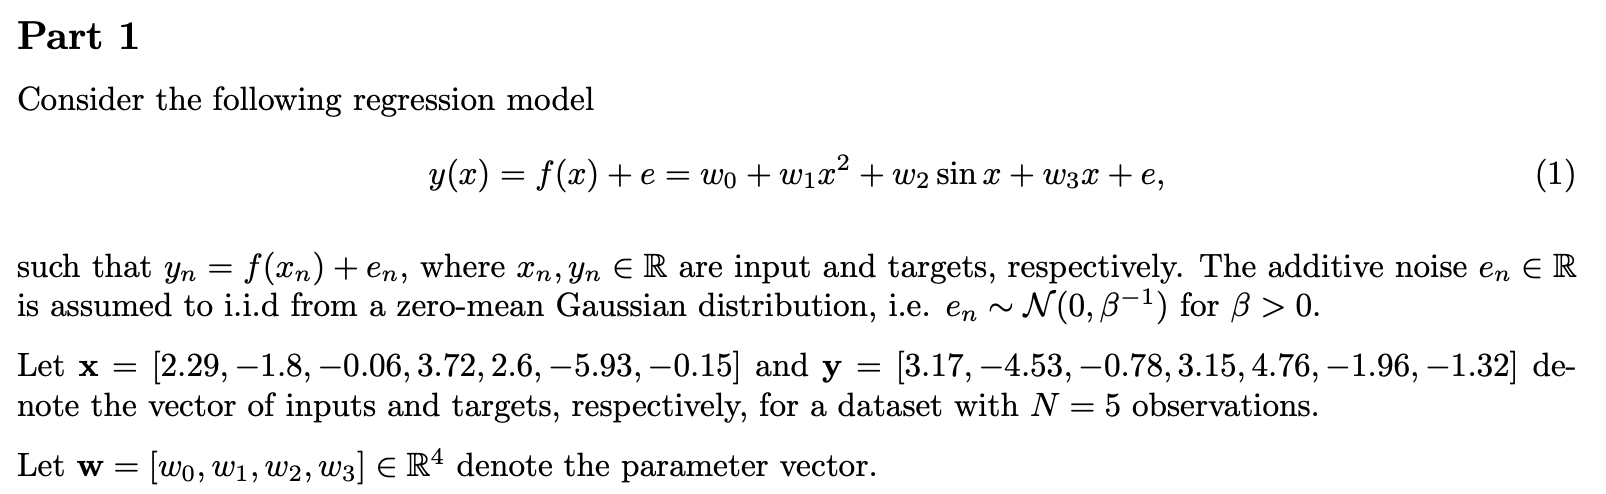

### Question 1.1: Compute and report a maximum likelihood estimate for w and β.

In [6]:
# Data
x = np.array([2.29, -1.8, -0.06, 3.72, 2.6, -5.93, -0.15])
y = np.array([3.17, -4.53, -0.78, 3.15, 4.76, -1.96, -1.32])
# w = [w0, w1, w2, w3]
N = 7
D = 4

# we define our dataset based on the data
# f = w0 + w1*x**2 + w2*sin(x) + w3*x + e
# where e ~ N(0, beta**-1)

Phi_train = np.zeros((N, D))
Phi_train[:, 0] = 1 # bias
Phi_train[:, 1] = x**2 # x^2
Phi_train[:, 2] = np.sin(x) # sin(x)
Phi_train[:, 3] = x # x

# We find the MLE for w and beta by maximizing the log likelihood
w_MLE = np.linalg.solve(Phi_train.T@Phi_train, Phi_train.T@y).ravel()

# Estimate beta (Noise Precision) by using Bishop (3.21)
# Predictions
y_pred = Phi_train @ w_MLE

# Residual sum of squares (RSS)
rss = np.sum((y - y_pred) ** 2)

# Estimating sigma^2 and beta
sigma_squared = rss / N
beta_MLE = 1 / sigma_squared

print(f"MLE for w: {w_MLE}")
print(f"MLE for beta: {beta_MLE}")

MLE for w: [-0.73483423  0.11247988  2.35754774  1.01247728]
MLE for beta: 4.841267709063771


### Question 1.2: Compute the posterior predictive distribution p(y∗|y, x∗ = 1)
where y∗ = y(x∗) using a plug-in approximation based on the maximum likelihood estimators for w and β.
Report the mean, standard deviation and a 95% credibility interval for y∗

In [7]:
# Plugin approximation is simply using the MLE for w and beta that we just found
x_star = 1
Phi_star = np.array([1, x_star**2, np.sin(x_star), x_star])

# Posterior predictive distribution
mean_star = Phi_star @ w_MLE
print(f"Mean of y*: {mean_star}")
print(f"Standard deviation of y*: {np.sqrt(1/beta_MLE)}") # from Murphy (4.197)
print(f"95% credibility interval for y*: [{mean_star - 1.96*np.sqrt(1/beta_MLE)}, {mean_star + 1.96*np.sqrt(1/beta_MLE)}]")

Mean of y*: 2.3739309472771275
Standard deviation of y*: 0.4544859382003122
95% credibility interval for y*: [1.4831385084045157, 3.2647233861497393]


Next, we impose i.i.d Gaussian priors on all regression coefficients $w_j \sim \mathcal{N}\left(0, \alpha^{-1}\right)$ for $j=0,1,2,3$ and assume $\alpha=1$ and $\beta=\frac{1}{2}$.

We quickly recall the posterior mean: **(From slide 31 Week 3)**

\begin{align*}
\mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{y}.  \tag{2}
\end{align*}

And the marginal posterior standard deviation:

\begin{align*}
\mathbf{S} &= \left(\alpha \mathbf{I} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}.  \tag{3}
\end{align*}

Where $\mathbf{\Phi}$ is the design matrix, $\mathbf{y}$ is the target vector, $\mathbf{I}$ is the identity matrix, and $\beta$ is the precision of the target variable. Furthermore, we will assume a zero-mean and isotropic Gaussian prior, i.e. $\mathbf{m}_0 = \mathbf{0}$, $\mathbf{S}_0 = \alpha^{-1}\mathbf{I}$.

### Question 1.3: Compute and report the posterior mean and marginal posterior standard deviation for each regression coefficient in w.

In [8]:
## Question 1.3: Compute and report the posterior mean and marginal posterior standard devi-ation for each regression coefficient in w.
alpha = 1
beta = 1/2

S0 = np.eye(D) * alpha**-1 
m0 = np.zeros(D) # 0's

S_N = np.linalg.inv(S0 + beta * Phi_train.T @ Phi_train)
m_N = beta * S_N @ Phi_train.T @ y

print(f"Posterior mean for w: {m_N}")
print(f"Marginal posterior standard deviation for w: {np.sqrt(np.diag(S_N))}")
print()

## OR WE CAN USE THE BAYESIAN LINEAR REGRESSION CLASS
model = BayesianLinearRegression(Phi_train, y[:, None], alpha=alpha, beta=beta)
print(f"Posterior mean for w: {model.m.ravel()}")
print(f"Marginal posterior standard deviation for w: {np.sqrt(np.diag(model.S))}")

Posterior mean for w: [-0.55802878  0.10888296  1.2586914   0.98545669]
Marginal posterior standard deviation for w: [0.60705599 0.0521089  0.70291928 0.20596948]

Posterior mean for w: [-0.55802878  0.10888296  1.2586914   0.98545669]
Marginal posterior standard deviation for w: [0.60705599 0.0521089  0.70291928 0.20596948]


### Question 1.4: Compute the analytical posterior predictive density p(y∗|y, x∗) for x∗ = 1.

We use slide 33 in week 3. 

\begin{align*}
m = \mathbf{m}^T\mathbf{\phi}(x^*) \\
\sigma^2_* = \mathbf{\phi}(x^*)^T\mathbf{S}\mathbf{\phi}(x^*) + \sigma^2
\end{align*}

So the final posterior predictive density is:

\begin{align*}
p(y^*|y, x^*=1) = \mathcal{N}(y_*|\mathbf{m}^T\mathbf{\phi}(x^*), \mathbf{\phi}(x^*)^T\mathbf{S}\mathbf{\phi}(x^*) + \sigma^2)
\end{align*}

In [9]:
# We calculate above
# Data
x_s = np.array([1])[:, None]
Phi_test = np.zeros((1, D))
Phi_test[:, 0] = 1 # bias
Phi_test[:, 1] = x_s**2 # x^2
Phi_test[:, 2] = np.sin(x_s) # sin(x)
Phi_test[:, 3] = x_s # x

# Calc
S_Ns = Phi_test @ S_N @ Phi_test.T + 1/beta
m_Ns = Phi_test @ m_N # Åbentbart omvendt ??
print(f"Posterior mean for y*: {m_Ns}")
print(f"Covariance for y*: {S_Ns}")
stats.norm.pdf(x_s, loc=m_Ns, scale=np.sqrt(S_Ns))
print()

## ELLER VI KAN GØRE DET MED BAYESIAN LINEAR REGRESSION CLASS
mu_star, var_star = model.predict_y(Phi_test)
print(f"Posterior mean for y*: {mu_star}")
print(f"Variance for y*: {var_star}")

Posterior mean for y*: [1.59546316]
Covariance for y*: [[2.6996761]]

Posterior mean for y*: [1.59546316]
Variance for y*: [2.6996761]


### Question 1.5: State the analytical expression for the marginal likelihood p(y|alpha, beta) 
and compute the value of log p(y|alpha = 1, beta = 1/2)

We recall from week 4 that:

$$
\begin{align*}
p(\mathbf{y}|\alpha, \beta) = \mathcal{N}(\mathbf{y}|\bm{0}, \alpha^{-1}\Phi^T \Phi + \beta^{-1}\mathbf{I})
\end{align*}
$$ 
is the marginal likelihood of the model. This is also often referred to as **maximum likelihood type II estimation**.

**Here we can use (3.86) from Bishop:**

$$
\begin{align*}
\ln p(\mathbf{t} \mid \alpha, \beta)=\frac{M}{2} \ln \alpha+\frac{N}{2} \ln \beta-E\left(\mathbf{m}_N\right)-\frac{1}{2} \ln |\mathbf{A}|-\frac{N}{2} \ln (2 \pi)
\end{align*}
$$

Where \(M\) is the number of parameters, $N$ is the number of data points, $\mathbf{m}_N$ is the posterior mean, and $\mathbf{A}= S_N^{-1}$ is the posterior precision matrix.

$E\left(\mathbf{m}_N\right)$ is the expected value of the posterior mean, which is given by:

$$
\begin{align*}
E\left(\mathbf{m}_N\right)=\frac{\beta}{2}\left\|\mathbf{t}-\boldsymbol{\Phi} \mathbf{m}_N\right\|^2+\frac{\alpha}{2} \mathbf{m}_N^{\mathrm{T}} \mathbf{m}_N
\end{align*}
$$

**from (3.82) in Bishop.**

In [10]:
A = np.linalg.inv(S_N)
Emn = beta/2 * np.sum((y - Phi_train @ m_N)**2) + alpha/2 * m_N.T @ m_N
mle2 = D/2 * np.log(alpha) + N/2*np.log(beta) - Emn - 1/2 * np.log(np.linalg.det(A)) - N/2 * np.log(2*np.pi)
print(f"mle2: {mle2.round(2)}")
print()

## ELLER VI KAN GØRE DET MED BAYESIAN LINEAR REGRESSION CLASS
print(f"Log marginal likelihood: {model.log_marginal_likelihood.round(2)}")

mle2: -17.24

Log marginal likelihood: -17.24


### Question 1.6: Use the Metropolis-Hastings algorithm to generate posterior samples from the distribution p(alpha, beta|y). 
Run 2 chains for 2000 iterations each. Initialize the first chain using
alpha = 1 and beta = 1 and the second chain using alpha = 10 and beta = 10. Choose an appropriate proposal
variance and justify your choice. Plot the trace of both parameters.

**Note:**

Here we recall that we have imposed a Gamma prior on alpha and beta.

  0%|          | 0/2000 [00:00<?, ?it/s, accept_rate=0]

100%|██████████| 2000/2000 [00:01<00:00, 1043.31it/s, accept_rate=0.341]


alpha: 
    Estimated mean: 0.998 
    MCSE: 0.054 
    95% CI: (0.151, 2.752)
beta: 
    Estimated mean: 1.187 
    MCSE: 0.058 
    95% CI: (0.182, 3.140)


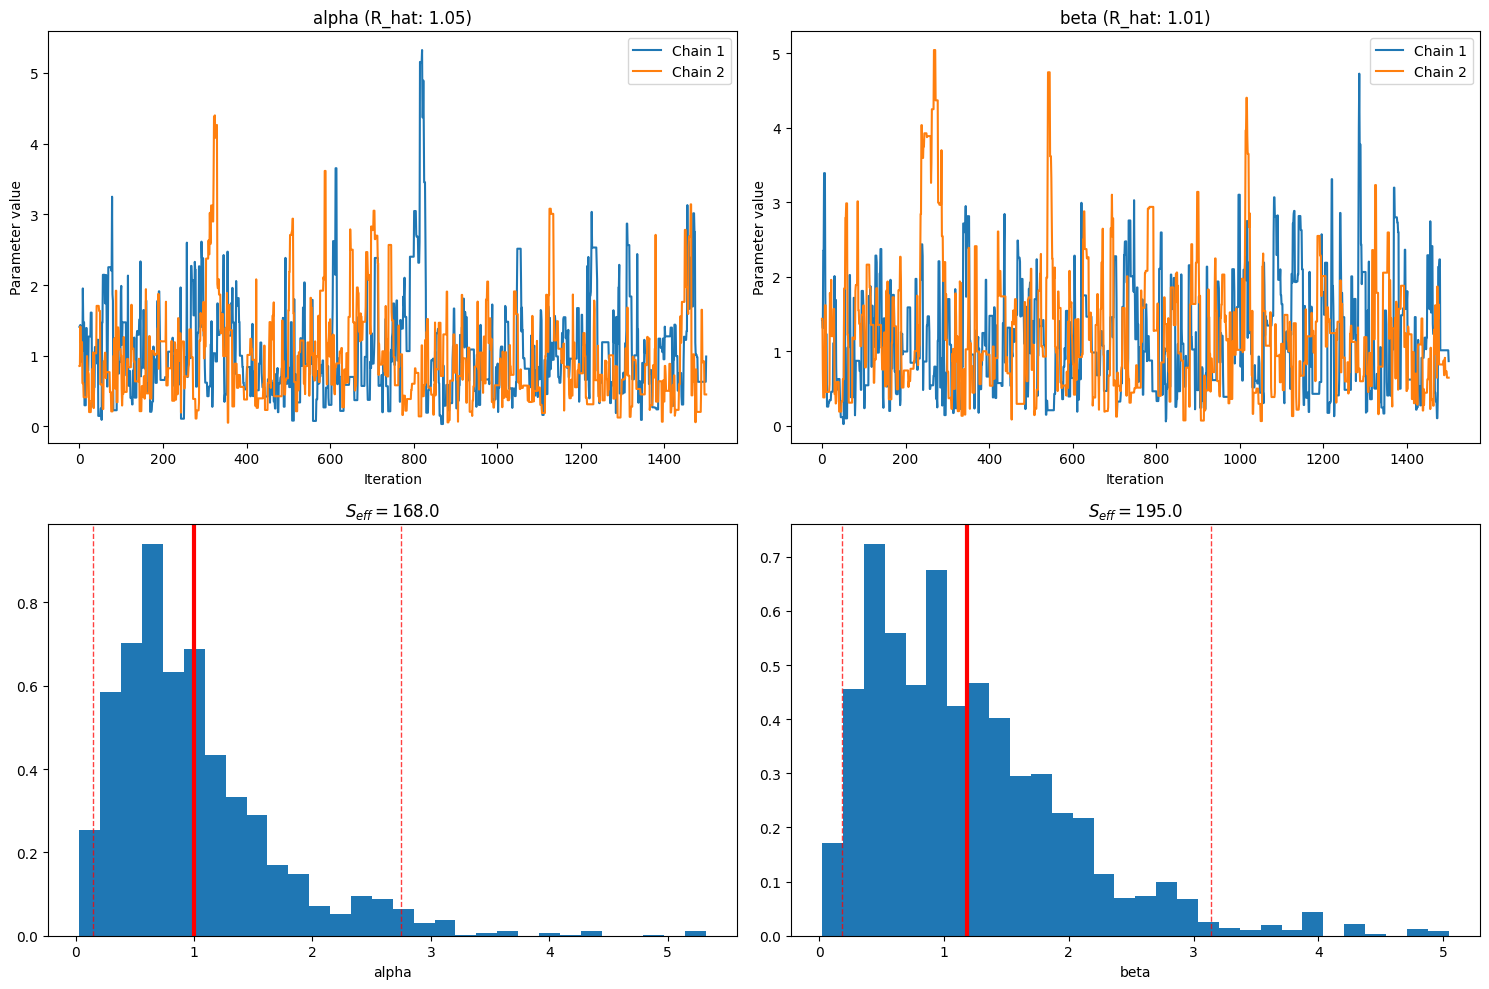

In [11]:
# We define our target distribution
log_gamma = lambda a: -a

def compute_marginal_likelihood(alpha, beta):
    """ computes and returns log marginal likelihood p(y|alpha, beta) """
    inv_S0 = alpha*np.identity(D)
    A = inv_S0 + beta*(Phi_train.T@Phi_train)
    m = beta*np.linalg.solve(A, Phi_train.T)@y       # (eq. 3.53 in Bishop)
    S = np.linalg.inv(A)                             # (eq. 3.54 in Bishop)
    Em = beta/2*np.sum((y - Phi_train@m)**2) + alpha/2*np.sum(m**2)
    return D/2*np.log(alpha) + N/2*np.log(beta) - Em - 0.5*np.linalg.slogdet(A)[1] - N/2*np.log(2*np.pi)

def target_dist(thetas):
    alpha, beta = thetas

    if alpha <= 0 or beta <= 0:
        return -np.Inf

    # Her kunne vi også bruge model.compute_marginal_likelihood(alpha, beta)
    return compute_marginal_likelihood(alpha, beta) + log_gamma(alpha) + log_gamma(beta)
    # return model.compute_marginal_likelihood(alpha, beta) + log_gamma(alpha) + log_gamma(beta)

num_iterations = 2000
warm_up = int(0.25*num_iterations)
tau = 1
num_params = 2
theta_init1 = np.stack(([1, 10], [1, 10]), 1)

thetas_1, accept_rates_1 = metropolis_multiple_chains(target_dist, num_params, 2, tau, num_iterations, theta_init1, warm_up=warm_up)

R_hat = compute_Rhat(thetas_1)
Seff = compute_effective_sample_size(thetas_1)

# Plot
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
titles = ["alpha", "beta"]

# Plot parameter values
for i in range(2):
    ax[0, i].set_title(titles[i] + f" (R_hat: {R_hat[i]:.2f})")
    for j in range(2):
        ax[0, i].plot(thetas_1[j, :, i], label=f"Chain {j+1}")
    ax[0, i].set_xlabel("Iteration")
    ax[0, i].set_ylabel("Parameter value")
    ax[0, i].legend()

# Plot histograms
for i in range(2):
    estimated_mean = np.mean(thetas_1[:,:,i].ravel())
    estimated_var = np.var(thetas_1[:,:,i].ravel())
    estimated_std = np.sqrt(estimated_var)
    MC_error = estimated_std/np.sqrt(Seff[i])
    cred_int1 = np.percentile(thetas_1[:,:,i].ravel(), 2.5)
    cred_int2 = np.percentile(thetas_1[:,:,i].ravel(), 97.5)
    ax[1, i].set_title(titles[i])
    ax[1, i].hist(thetas_1[:, :, i].flatten(), 30, density=True)
    ax[1, i].set(title=f'$S_{{eff}}= {Seff[i]:3.1f}$', xlabel=titles[i])
    ax[1, i].axvline(estimated_mean, color='r', linestyle='-', linewidth=3, label='Estimated mean')
    ax[1, i].axvline(cred_int1, color='r', linestyle='--', linewidth=1, alpha=0.75)
    ax[1, i].axvline(cred_int2, color='r', linestyle='--', linewidth=1, label='95% interval', alpha=0.75)

    print(f"{titles[i]}: \n    Estimated mean: {estimated_mean:2.3f} \n    MCSE: {MC_error:2.3f} \n    95% CI: ({cred_int1:2.3f}, {cred_int2:2.3f})")

plt.tight_layout()
plt.show()


## Part 2

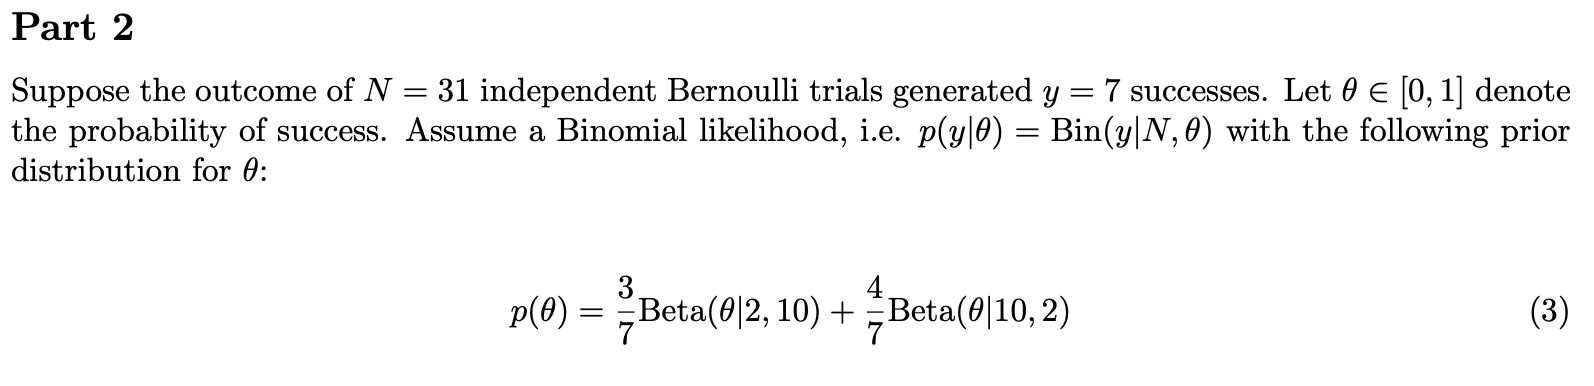

### Question 2.1: Compute the prior probability of the event θ > 1/2

We can use the **Cumulative Density Function** for caluclating the probability of the event $\theta < 1/2$ and then negate it to get the probability of the event $\theta > 1/2$.

In [12]:
# Data
N = 31
y = 7

(3/7*(1-stats.beta.cdf(0.5, 2, 10)) + 4/7*(1-stats.beta.cdf(0.5, 10, 2))).round(2)

0.57

### Question 2.2: Compute the analytical marginal likelihood p(y) and evaluate p(y = 7)

We use **Week 1** or **(4.135) from Murphy**:

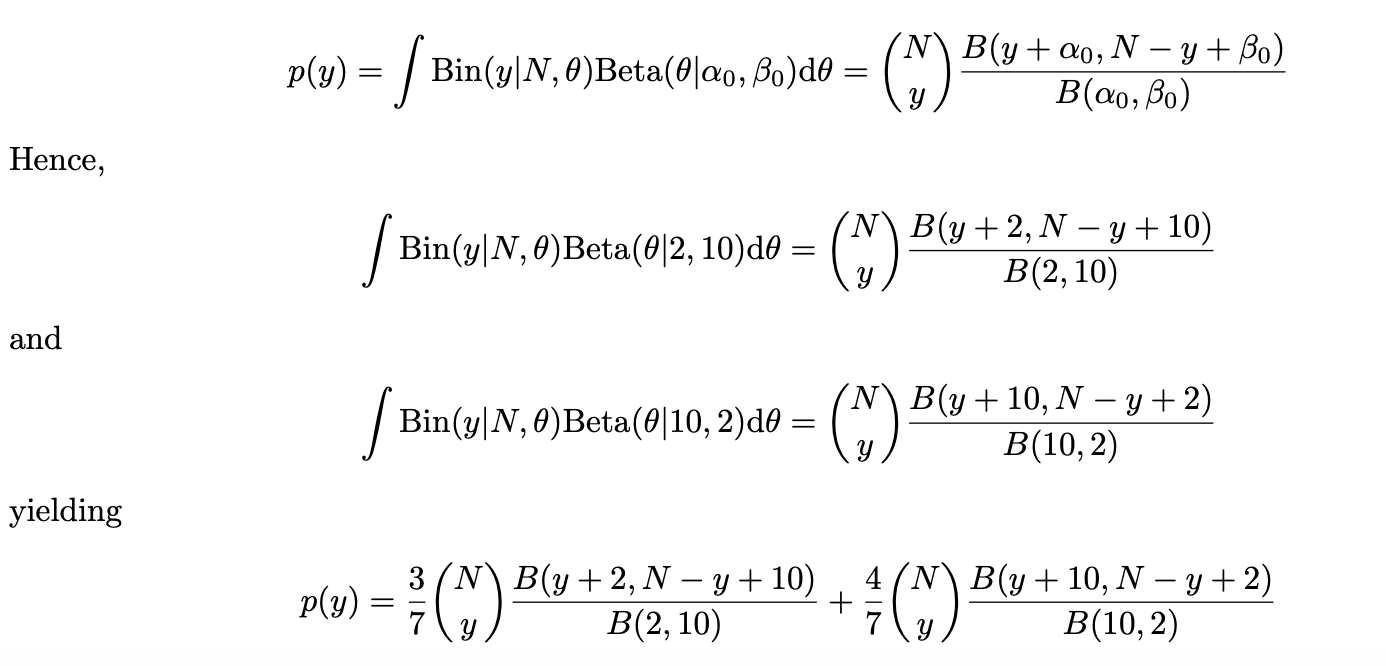

In [13]:
# We can then evaluate this
special.binom(N, y)*3/7*special.beta(y+2,N-y+10)/special.beta(2,10) + special.binom(N, y)*4/7*special.beta(y+10,N-y+2)/special.beta(10,2)

0.030929000681214784

## Part 3

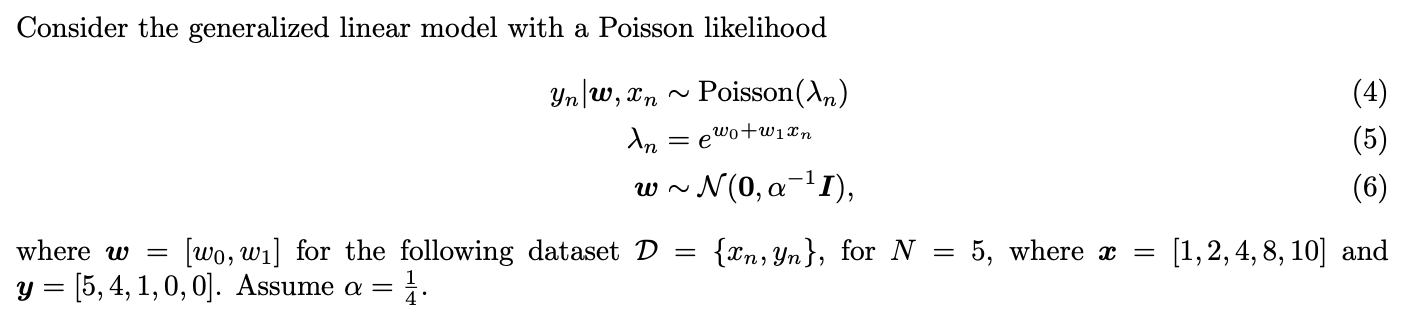

### Question 3.1: Plot the contours of the prior distribution, the log likelihood and the posterior
for the ranges w0 ∈ [−3.5, 3.5] and w1 ∈ [−3.5, 3.5].

Oh no the normal is not conjugate to the Poisson distribution! We already anticipate a problem.

Our prior is simply a Normal with mean 0 and variance $\alpha$.

In [ ]:
# Data
X = np.array([1,2,4,8,10])
y = np.array([5,4,1,0,0])

**Check Week 8 for Poisson joint etc.**

In [15]:
alpha = 1/4

log_npdf = lambda x, m, v: -0.5*np.log(2*np.pi*v) -0.5*(x-m)**2/v 

# From week 3 - but we could also use Week 8
def log_prior(a, b):
    return (log_npdf(a, 0, 1/alpha) + log_npdf(b, 0,1/alpha)).sum(axis=2)

def log_likelihood(w0, w1):
    l = stats.poisson.logpmf(y, np.exp(w0 + w1*X)).sum(axis=2)
    return l

def log_posterior(a, b):
    return log_prior(a, b) + log_likelihood(a, b)

def design_matrix(x):
    return np.column_stack((np.ones(len(x)), x))

In [16]:
num_w0, num_w1 = 90, 100
w0 = np.linspace(-3.5, 3.5, num_w0)
w1 = np.linspace(-3.5, 3.5, num_w1)

log_prior_grid = Grid2D(w0, w1, log_prior, 'Prior')
log_lik_grid = Grid2D(w0, w1, log_likelihood, 'Likelihood')
log_joint_grid = Grid2D(w0, w1, log_posterior, 'Posterior')

**OBS We made it with log all the way through**

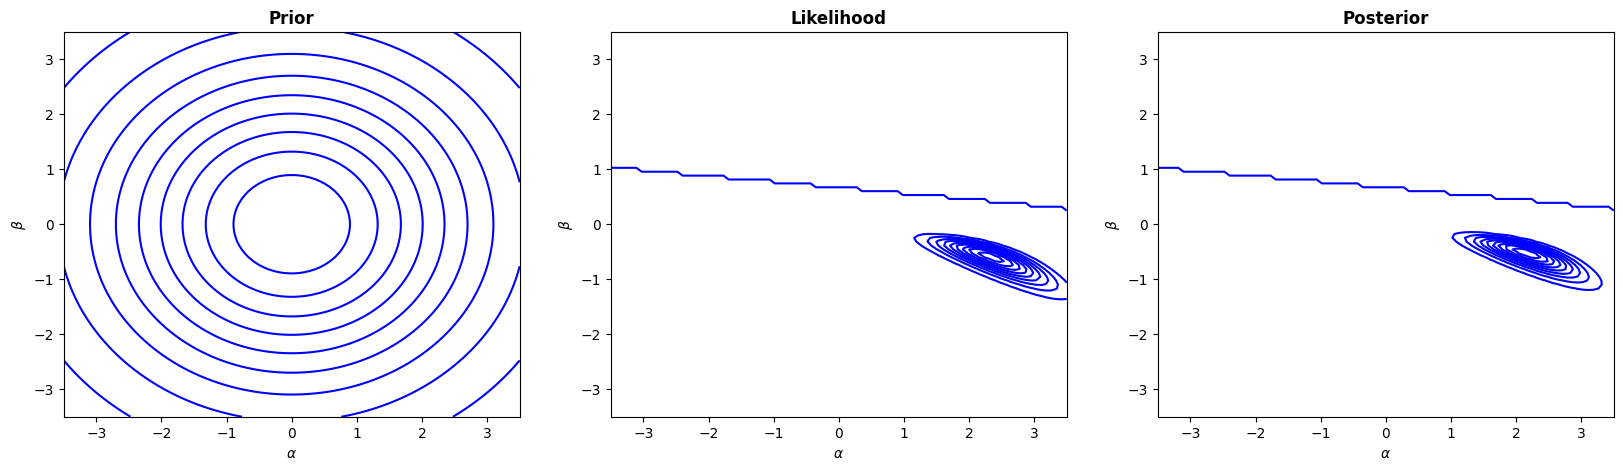

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
log_prior_grid.plot_contours(ax[0], f=np.exp)
log_lik_grid.plot_contours(ax[1], f=np.exp)
log_joint_grid.plot_contours(ax[2], f=np.exp)

### Question 3.2: Write the logarithm of the joint distribution p(y, w) 
and absorb all terms that are constant wrt. w into a constant K ∈ R.

We see that $p(y)$ is a Poisson distribution and $p(w)$ is a normal distribution. We can write the joint distribution as:

**We use slide 13 for Bayesian Poisson Regression II**

We define the poisson and log poisson:
$$
p(k | \lambda)=\prod_{i=1}^{n} \frac{\lambda^{y_{i}} e^{-\lambda}}{y_{i} !}
$$

$$
\log L(\lambda | k)=\sum_{i=1}^{n}\left(y_{i} \log (\lambda)-\lambda-\log \left(y_{i}!\right)\right)
$$

Along with the log normal:

$$
\log \mathcal{N}(w|\mu, \sigma^2) = -\frac{1}{2\sigma^2}w^2+\frac{\mu}{\sigma^2}w+K
$$

$$
\begin{align*}

p(\boldsymbol{y}, \boldsymbol{w})=\prod_{n=1}^N p\left(y_n \mid \boldsymbol{w}, x_n\right) p(\boldsymbol{w})=\mathcal{N}\left(\boldsymbol{w} \mid \mathbf{0}, \alpha^{-1} \boldsymbol{I}\right) \prod_{n=1}^N \frac{\lambda_n^{y_n} e^{-\lambda_n}}{y_{n}!}

\end{align*}
$$

\begin{aligned}
\log p(\boldsymbol{y}, \boldsymbol{w}) & =\sum_{n=1}^N \log p\left(y_n \mid \boldsymbol{w}, x_n\right)+\log p(\boldsymbol{w}) \\
& =-\frac{1}{2} \log (2 \pi)-\frac{1}{2} \alpha \boldsymbol{w}^T \boldsymbol{w}+\sum_{n=1}^N \log \frac{\lambda_n^{y_n} e^{-\lambda_n}}{y_{n}!} \\
& =-\frac{1}{2} \log (2 \pi)-\frac{1}{2} \alpha \boldsymbol{w}^T \boldsymbol{w}+\sum_{n=1}^N\left[y_n \log \lambda_n-\lambda_n+\log \frac{1}{y_{n}!}\right] \\
& =-\frac{1}{2} \alpha \boldsymbol{w}^T \boldsymbol{w}+\sum_{n=1}^N\left[y_n \log \lambda_n-\lambda_n\right]+K \\
& =-\frac{1}{2} \alpha \boldsymbol{w}^T \boldsymbol{w}+\sum_{n=1}^N y_n \log \lambda_n-\sum_{n=1}^N \lambda_n+K
\end{aligned}

### Question 3.3: Compute the Hessian of log p(y, w) with respect to w 
and evaluate it at the mode of p(w|y).

Now we want to do some Laplace approximation and for that we need to compute the Hessian of our Joint probability.

Usually we want to identify the $w_{MAP}$ but it is given as:

$$
w_{MAP} = [2.1575, -0.5201]^T
$$

We could estimate it with the following:

$\boldsymbol{w}_{\mathrm{MAP}}=\arg \max _{\boldsymbol{w}} p(\boldsymbol{w} \mid \boldsymbol{y})=\arg \max _{\boldsymbol{w}} p(\boldsymbol{y} \mid \boldsymbol{w}) p(\boldsymbol{w})$

We calculate the Hessian through:

$$
\nabla_{\mathbf{w}}^2 \log p(\mathbf{y}, \mathbf{w})=\sum_{n=1}^N \nabla_{\mathbf{w}}^2 \log p\left(y_n \mid w_n\right)
$$

We can evaluate the Hessian with:

$$
\boldsymbol{A}=-\left.\nabla \nabla \ln p(\boldsymbol{w} \mid \boldsymbol{y}) p(\boldsymbol{w})\right|_{\boldsymbol{w}=\boldsymbol{w}_{\mathrm{MAP}}}
$$

In [36]:
# In code we can do this with the autograd package
from autograd import hessian
import autograd.numpy as autonp
import autograd.scipy.stats as autostats

log_npdf = lambda x, m, v: -0.5*autonp.log(2*autonp.pi*v) -0.5*(x-m)**2/v 

def log_prior(a, b):
    return (log_npdf(a, 0, 1/alpha) + log_npdf(b, 0,1/alpha))

def log_likelihood(w0, w1):
    l = autonp.sum(autostats.poisson.logpmf(y, autonp.exp(w0 + w1*X)))
    return l

# Our log joint is simply the one we defined earlier
def log_posterior(w_flat):
    a = w_flat[0]
    b = w_flat[1]
    return log_prior(a, b) + log_likelihood(a, b)

cost_fun = lambda W: -log_posterior(W)

w_MAP = np.array([2.1575,-0.5201])

hess = hessian(log_posterior)(w_MAP)
hess

array([[ -9.711081  , -17.13135724],
       [-17.13135724, -48.30024432]])

### Question 3.4: Construct a Laplace approximation of p(w|y)

We conduct Laplace Approximation in accordance with Exercise 7.

$$\begin{align*}
p(\mathbf{w}_{\text{flat}}|\mathbf{y}) \approx q(\mathbf{w}_{\text{flat}}) = \mathcal{N}(\mathbf{w}_{\text{flat}}|\mathbf{m}, \mathbf{S}), 
\end{align*}$$

In [35]:
def compute_laplace_approximation(w_MAP):
    """ computes Laplace approximation of model """

    w_init_flat = np.zeros(len(w_MAP))
    cost_fun = lambda W: -log_posterior(W)
    result = minimize(value_and_grad(cost_fun), w_init_flat, jac=True)

    if result.success:
        w_MAP = result.x
        m_flat = w_MAP[:, None]    
        A_flat = hessian(cost_fun)(w_MAP)
        S_flat = np.linalg.inv(A_flat)
        return m_flat, S_flat
    else:
        print('Warning optimization failed')
        return None, None

m, S = compute_laplace_approximation(w_MAP)

print("We get the mean, m: ", m)
print()
print("Along with the covariance, S: ",S)


We get the mean, m:  [[ 2.15750455]
 [-0.5201292 ]]

Along with the covariance, S:  [[ 0.27513573 -0.09759115]
 [-0.09759115  0.05532219]]


### Question 3.5: Compute the mean and variance of the posterior predictive probability 
p(y∗|y, x∗ =0), where y∗ = y(x∗) via the Laplace approximation and Monte Carlo sampling. Use S = 1000
Monte Carlo samples.

We know from **Exercise 7**, that to make predictions, we approximate the posterior predictive distribution using Monte Carlo. 

$$\begin{align*}
p(y^* = k|\mathbf{y}, \mathbf{x}^*) \approx \int p(y^* =k| \mathbf{W}) q(\mathbf{W})\text{d}\mathbf{W} \approx \frac{1}{S} \sum_{j=1}^S p(y^* =k| \mathbf{W}^{(j)}) \quad\text{for}\quad \mathbf{W}^{(j)} \sim q(\mathbf{W})
\end{align*}$$

 for $j = 1, \dots, S$. To implement this, we simply draw the samples from $\mathbf{w}_{\text{flat}}^{(j)} \sim \mathcal{N}(\mathbf{w}_{\text{flat}}|\mathbf{m}, \mathbf{S})$ and then reshape each sample into $\mathbf{W}^{(j)} \in \mathbb{R}^{K\times D}$.

**We recall that our probability is a Poisson distribution**.

In [88]:
# We already have the mean and covariance, m and S from the laplace approximation.
# From Exercise 7 we get:
num_samples = 1000
# We generate some sample x^*
x_star = np.array([1, 0])

# Draw samples (shape: num_samples x total_params)
w_samples_flat = np.random.multivariate_normal(m.ravel(), S, size=num_samples)

# We generate some samples of y^* using the laplace approximation
lambda_samples = [np.exp(wi[0] + wi[1]*x_star) for wi in w_samples_flat]

# We can then evaluate and get y^*
ystar_samples = np.random.poisson(lambda_samples)
np.mean(ystar_samples), np.var(ystar_samples)

(7.7905, 31.68660975)

### Question 3.6: What would happen to the posterior predictive distribution p(y∗|y, x∗ = 0) 
if α → ∞? Explain your reasoning.